Shape: (518, 72)
Columns: ['Quarter', 'State', 'Total_Crashes', 'Num_Injured', 'Num_Killed', 'Total_Vehicles_Involved', 'SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors', 'Quarter_Num', 'Year', 'Quarter_Date', 'Total_Casualties', 'Casualty_Rate', 'Fatality_Rate', 'Vehicles_per_Crash', 'Total_Factors', 'SPV_Prop', 'DAD_Prop', 'PWR_Prop', 'FTQ_Prop', 'Other_Factors_Prop', 'Quarter_Sin', 'Quarter_Cos', 'Severe_Crash', 'High_Casualty', 'State_Encoded', 'State_Adamawa', 'State_Akwa Ibom', 'State_Anambra', 'State_Bauchi', 'State_Bayelsa', 'State_Benue', 'State_Borno', 'State_Cross River', 'State_Delta', 'State_Ebonyi', 'State_Edo', 'State_Ekiti', 'State_Enugu', 'State_FCT', 'State_Gombe', 'State_Imo', 'State_Jigawa', 'State_Kaduna', 'State_Kano', 'State_Katsina', 'State_Kebbi', 'State_Kogi', 'State_Kwara', 'State_Lagos', 'State_Nasarawa', 'State_Niger', 'State_Ogun', 'State_Ondo', 'State_Osun', 'State_Oyo', 'State_Plateau', 'State_Rivers', 'State_Sokoto', 'State_Taraba', 'State_Yobe', 'State_Zamfa

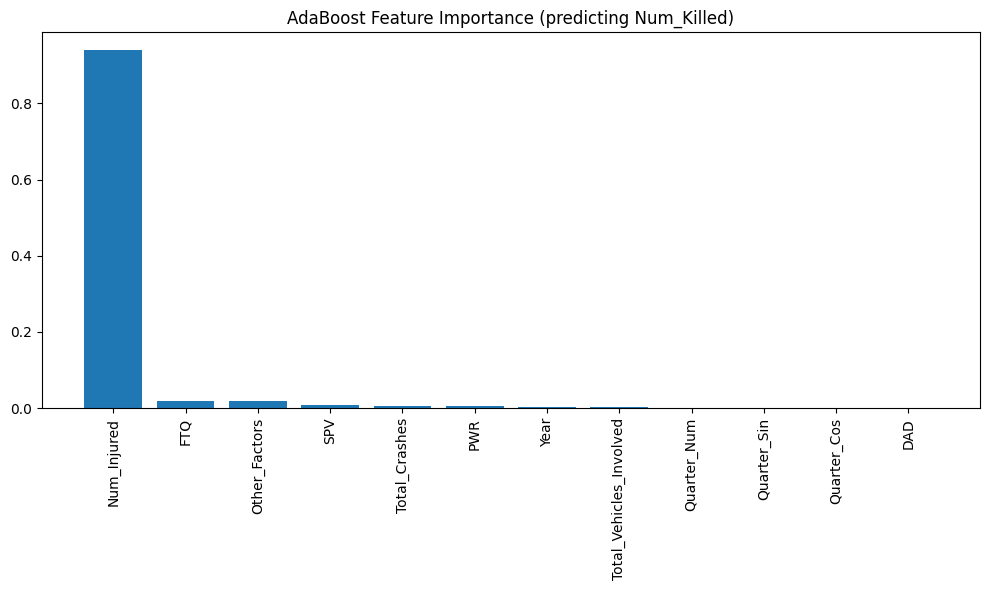

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ------------------------------
# 1. Load the dataset
# ------------------------------
# In a real environment, read the CSV file:
# df = pd.read_csv('Nigeria Crash Data P.csv')

# For this example, the content is pasted as a string (as provided)

df = pd.read_csv("Nigeria Crash Data P.csv")

# ------------------------------
# 2. Basic cleaning & inspection
# ------------------------------
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())
# No missing values, good.

# ------------------------------
# 3. Define target and features
# ------------------------------
target = 'Num_Killed'

# Drop columns that would cause leakage or are redundant:
#   - Directly derived from target: Total_Casualties, Casualty_Rate, Fatality_Rate
#   - Derived from other columns: Vehicles_per_Crash, Total_Factors,
#     SPV_Prop, DAD_Prop, PWR_Prop, FTQ_Prop, Other_Factors_Prop
#   - Boolean flags derived from thresholds: Severe_Crash, High_Casualty
#   - String/date columns not useful as numbers: Quarter, Quarter_Date, State, Region
#   - Encoded columns that duplicate one‑hot dummies: State_Encoded, Region_Encoded
leakage_cols = [
    'Total_Casualties', 'Casualty_Rate', 'Fatality_Rate',
    'Vehicles_per_Crash', 'Total_Factors',
    'SPV_Prop', 'DAD_Prop', 'PWR_Prop', 'FTQ_Prop', 'Other_Factors_Prop',
    'Severe_Crash', 'High_Casualty',
    'Quarter', 'Quarter_Date', 'State', 'Region',
    'State_Encoded', 'Region_Encoded'
]
X = df.drop(columns=[target] + leakage_cols)
y = df[target]

# Keep only numeric columns (all remaining should be numeric)
X = X.select_dtypes(include=[np.number])

print("Remaining features:", X.columns.tolist())
print(f"X shape: {X.shape}, y shape: {y.shape}")

# ------------------------------
# 4. Train / test split (chronological)
# ------------------------------
# To avoid using future data to predict the past, split by time.
# The dataset runs from Q4 2020 to Q1 2024. Use 2020‑2022 for training,
# 2023‑2024 for testing.
train_mask = df['Year'] <= 2022
test_mask = df['Year'] >= 2023

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# ------------------------------
# 5. Feature scaling (optional, not strictly needed for tree‑based)
# ------------------------------
# AdaBoost uses decision trees – scaling is not required.
# But it can help with interpretation or if other models are compared.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# 6. AdaBoostRegressor with hyperparameter tuning
# ------------------------------
# Base estimator: decision tree with limited depth (default max_depth=3)
ada = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    random_state=42
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential']   # available in AdaBoostRegressor
}

grid_search = GridSearchCV(
    ada,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV MAE (neg):", -grid_search.best_score_)

# ------------------------------
# 7. Evaluate on test set
# ------------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nTest Set Performance:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.2f}")

# ------------------------------
# 8. Feature importance
# ------------------------------
importances = best_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("AdaBoost Feature Importance (predicting Num_Killed)")
plt.bar(range(len(indices[:20])), importances[indices[:20]])
plt.xticks(range(len(indices[:20])), feature_names[indices[:20]], rotation=90)
plt.tight_layout()
plt.show()